In [1]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
from AdaBelief import AdaBelief
from RAdam import RAdam
from AdamW import AdamW

In [3]:
# sample IsNext and NotNext to be same in small batch size
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences)) # sample random index in sentences
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]
        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        # MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
    return batch
# Proprecessing Finished

In [4]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [5]:
def gelu(x):
    "Implementation of the gelu activation function by Hugging Face"
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [6]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

In [9]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(gelu(self.fc1(x)))

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [11]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf

In [12]:
def plot(curve_type='result', curve_data = dict(), ylim=(0,30)):
    plt.figure()
    plt.ylim(ylim)
    labels = list(curve_data.keys());
    for i,label in zip(curve_data.keys(),labels) :
        acc = np.array(curve_data[i])
    
        
        if label == 'AdaBelief':
            plt.plot(acc, '-' ,label = label)
        else:
            plt.plot(acc, '--',label = label)
    
    plt.grid()
    plt.legend(fontsize=14, loc='lower left')
    plt.title('{} set cost ~ epoch'.format(curve_type))
    plt.xlabel('Epoch')
    plt.ylabel('Cost')

In [13]:
curve_data = dict()

# BERT Parameters
maxlen = 30 # maximum of length
batch_size = 6
max_pred = 5  # max tokens of prediction
n_layers = 6 # number of Encoder of Encoder Layer
n_heads = 12 # number of heads in Multi-Head Attention
d_model = 768 # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

text = (
    'Hello, how are you? I am Romeo.\n'
    'Hello, Romeo My name is Juliet. Nice to meet you.\n'
    'Nice meet you too. How are you today?\n'
    'Great. My baseball team won the competition.\n'
    'Oh Congratulations, Juliet\n'
    'Thanks you Romeo'
)
sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'
word_list = list(set(" ".join(sentences).split()))
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(word_list):
    word_dict[w] = i + 4
number_dict = {i: w for i, w in enumerate(word_dict)}
vocab_size = len(word_dict)

token_list = list()
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)

In [14]:
def train(args):    

    model = BERT()
    
    criterion = nn.CrossEntropyLoss()
    
    params = model.parameters()
    
    print(args.optimizer)
    
    if args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(params, lr=args.lr, weight_decay=args.wdecay)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(params, lr=args.lr, weight_decay=args.wdecay)
    if args.optimizer == 'adamw':
        optimizer = AdamW(params, lr=args.lr, weight_decay=args.wdecay)
    if args.optimizer == 'radam':
        optimizer = RAdam(params, lr=args.lr, weight_decay=args.wdecay)
    if args.optimizer.lower() == 'adabelief':
        optimizer = AdaBelief(params, lr=args.lr, weight_decay=args.wdecay,
                             eps=args.eps, betas=(args.beta1, args.beta2))
    if args.optimizer == 'adabound':
        optimizer = AdaBound(params, lr=args.lr, weight_decay=args.wdecay, final_lr=30, gamma=1e-3)
    if args.optimizer == 'amsbound':
        optimizer = AdaBound(params, lr=args.lr, weight_decay=args.wdecay, final_lr=30, gamma=1e-3, amsbound=True)
    elif args.optimizer == 'msvag':
        optimizer = MSVAG(params, args.lr, betas=(args.beta1, args.beta2),
                          weight_decay=args.wdecay)
    
    curve_data[args.optimizer] = list()

    batch = make_batch()
    input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

    for epoch in range(200):
        optimizer.zero_grad()
        logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
        loss = loss_lm + loss_clsf
        loss_str = '{:.6f}'.format(loss)
        curve_data[args.optimizer].append(float(loss_str))
        if (epoch + 1) % 10 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', loss_str)
        loss.backward()
        optimizer.step()

    # Predict mask tokens ans isNext
    input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))
    print(text)
    print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])

    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
    logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
    print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
    print('predict masked tokens list : ',[pos for pos in logits_lm if pos != 0])

    logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]
    print('isNext : ', True if isNext else False)
    print('predict isNext : ',True if logits_clsf else False)

In [15]:
class Args(object):
    def __init__(self, optimizer='AdaBelief', lr=0.001, wdecay = False, beta1=0.9, beta2=0.999, eps=1e-14):
        self.optimizer = optimizer
        self.lr = lr
        self.wdecay = wdecay
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

In [16]:
args = Args(optimizer='AdaBelief', lr=0.001, wdecay = False, beta1=0.9, beta2=0.999, eps=1e-14)

In [17]:
def create_args_list(lr=0.001, wdecay = False, beta1=0.9, beta2=0.999,eps=1e-14):
    args_list=[]
    args_list.append(Args(optimizer='AdaBelief', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps)) 
    args_list.append(Args(optimizer='sgd', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    args_list.append(Args(optimizer='adam', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    args_list.append(Args(optimizer='adamw', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    args_list.append(Args(optimizer='radam', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    return args_list

In [18]:
args_list = create_args_list(lr=0.001, wdecay=False, beta1=0.9,beta2=0.999,eps=1e-16)

In [19]:
curve_data.clear()
for args in args_list:
    train(args)

AdaBelief


/home/viewv/ML/nlp-tutorial/5-2.BERT/AdaBelief.py:145: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 0010 cost = 55.973652
Epoch: 0020 cost = 39.658901
Epoch: 0030 cost = 18.463158
Epoch: 0040 cost = 7.250122
Epoch: 0050 cost = 5.328564
Epoch: 0060 cost = 4.370602
Epoch: 0070 cost = 3.543177
Epoch: 0080 cost = 3.082668
Epoch: 0090 cost = 3.329046
Epoch: 0100 cost = 3.788906
Epoch: 0110 cost = 3.423995
Epoch: 0120 cost = 3.278953
Epoch: 0130 cost = 3.411097
Epoch: 0140 cost = 3.934496
Epoch: 0150 cost = 3.008049
Epoch: 0160 cost = 3.206666
Epoch: 0170 cost = 3.259302
Epoch: 0180 cost = 2.888352
Epoch: 0190 cost = 2.816701
Epoch: 0200 cost = 2.931439
Hello, how are you? I am Romeo.
Hello, Romeo My name is Juliet. Nice to meet you.
Nice meet you too. How are you today?
Great. My baseball team won the competition.
Oh Congratulations, Juliet
Thanks you Romeo
['[CLS]', '[MASK]', 'how', '[MASK]', 'you', 'i', 'am', 'romeo', '[SEP]', 'hello', '[MASK]', 'are', 'you', 'i', 'am', 'romeo', '[SEP]']
masked tokens list :  [5, 13, 28]
predict masked tokens list :  []
isNext :  False
predict is

<IPython.core.display.Javascript object>


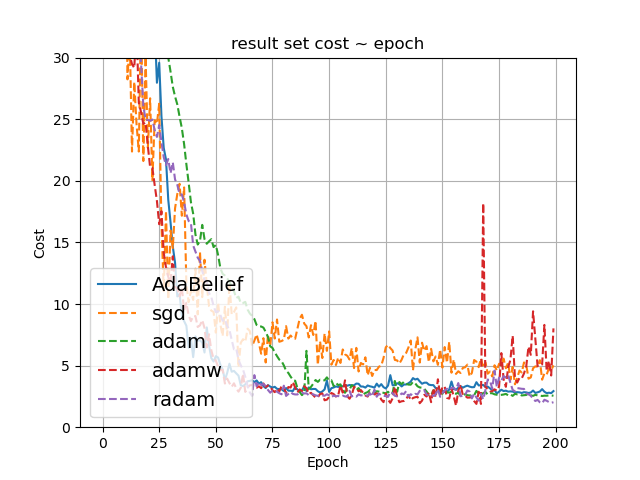

In [20]:
plot(curve_data=curve_data, ylim=(0,30))

In [21]:
curve_data.clear()
for args in args_list:
    train(args)

AdaBelief
Epoch: 0010 cost = 36.073425
Epoch: 0020 cost = 35.801113
Epoch: 0030 cost = 25.794729
Epoch: 0040 cost = 18.978806
Epoch: 0050 cost = 18.460957
Epoch: 0060 cost = 9.796633
Epoch: 0070 cost = 7.003100
Epoch: 0080 cost = 4.105091
Epoch: 0090 cost = 3.533008
Epoch: 0100 cost = 2.702866
Epoch: 0110 cost = 3.464279
Epoch: 0120 cost = 2.042766
Epoch: 0130 cost = 3.829336
Epoch: 0140 cost = 2.402957
Epoch: 0150 cost = 2.378239
Epoch: 0160 cost = 2.337265
Epoch: 0170 cost = 2.892493
Epoch: 0180 cost = 2.270549
Epoch: 0190 cost = 1.954126
Epoch: 0200 cost = 12.383484
Hello, how are you? I am Romeo.
Hello, Romeo My name is Juliet. Nice to meet you.
Nice meet you too. How are you today?
Great. My baseball team won the competition.
Oh Congratulations, Juliet
Thanks you Romeo
['[CLS]', 'thanks', 'you', 'romeo', '[SEP]', 'oh', 'congratulations', 'juliet', '[SEP]']
masked tokens list :  [4]
predict masked tokens list :  []
isNext :  False
predict isNext :  True
sgd
Epoch: 0010 cost = 63.99

<IPython.core.display.Javascript object>


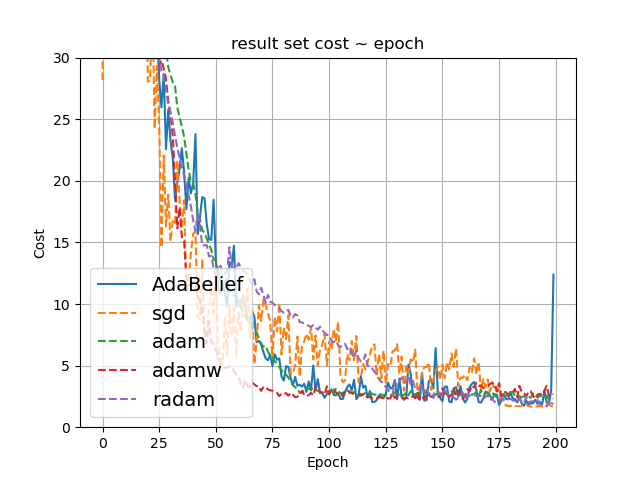

In [22]:
plot(curve_data=curve_data, ylim=(0,30))

In [23]:
args_list = create_args_list(lr=0.001, wdecay=False, beta1=0.9,beta2=0.999,eps=1e-15)
curve_data.clear()
for args in args_list:
    train(args)

AdaBelief
Epoch: 0010 cost = 46.903595
Epoch: 0020 cost = 9.911850
Epoch: 0030 cost = 9.712451
Epoch: 0040 cost = 5.961070
Epoch: 0050 cost = 3.199056
Epoch: 0060 cost = 2.447088
Epoch: 0070 cost = 3.141012
Epoch: 0080 cost = 3.870083
Epoch: 0090 cost = 3.626605
Epoch: 0100 cost = 4.267189
Epoch: 0110 cost = 3.632255
Epoch: 0120 cost = 4.674650
Epoch: 0130 cost = 4.870369
Epoch: 0140 cost = 2.841543
Epoch: 0150 cost = 10.972808
Epoch: 0160 cost = 2.956264
Epoch: 0170 cost = 2.327161
Epoch: 0180 cost = 2.403877
Epoch: 0190 cost = 2.022810
Epoch: 0200 cost = 2.460493
Hello, how are you? I am Romeo.
Hello, Romeo My name is Juliet. Nice to meet you.
Nice meet you too. How are you today?
Great. My baseball team won the competition.
Oh Congratulations, Juliet
Thanks you Romeo
['[CLS]', 'nice', 'meet', 'you', 'too', '[MASK]', 'are', 'you', 'today', '[SEP]', 'hello', 'how', 'are', '[MASK]', '[MASK]', 'am', 'romeo', '[SEP]']
masked tokens list :  [22, 7, 5]
predict masked tokens list :  []
isNe

<IPython.core.display.Javascript object>


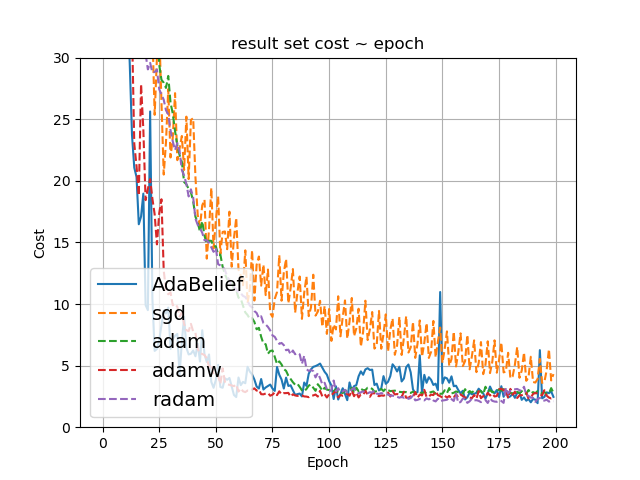

In [24]:
plot(curve_data=curve_data, ylim=(0,30))